In [61]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [62]:
df = pd.read_csv('./data/laptops.csv/bank-full.csv', delimiter = ';')

In [63]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [64]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [65]:
df.y.value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [66]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [67]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.y = (df.y == 'yes').astype(int)

df.y.value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [113]:
features = ['age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y']

numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


df = df[features]

In [69]:
SEED = 1

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [70]:
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# Question 1 : ROC AUC feature importance

In [71]:
for c in numerical :
        auc = roc_auc_score(y_train, df_train[c])
        if auc < .5 :
            auc = roc_auc_score(y_train, -df_train[c])
        print(c, round(auc,3))
        print()

age 0.512

balance 0.589

day 0.526

duration 0.815

campaign 0.571

pdays 0.59

previous 0.599



# Question 2: Training the model

In [90]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [93]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_pred)

print(auc_val)

0.9002510973902931


In [94]:
y_pred[:30]

array([0.0287949 , 0.02264852, 0.02128679, 0.01481543, 0.02706556,
       0.0369329 , 0.05171735, 0.03405757, 0.06078684, 0.00648587,
       0.6850276 , 0.04189691, 0.00677457, 0.012127  , 0.03754516,
       0.08572455, 0.11574913, 0.08009031, 0.08173398, 0.00300687,
       0.00755868, 0.03627363, 0.43406481, 0.03908153, 0.10072683,
       0.02358224, 0.02046184, 0.02076523, 0.64561695, 0.06137304])

# Question 3 : Precision and Recall

In [114]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [115]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [116]:
scores = []

thresholds = np.linspace(0, 1, 101)


for t in thresholds :
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
        
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()


    scores.append((t, tp, fp, fn, tn))

In [117]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

df_scores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,1098,7944,0,0,1.000000,1.000000
1,0.01,1094,6983,4,961,0.996357,0.879028
2,0.02,1093,5773,5,2171,0.995446,0.726712
3,0.03,1087,4717,11,3227,0.989982,0.593781
4,0.04,1066,3796,32,4148,0.970856,0.477845
...,...,...,...,...,...,...,...
96,0.96,30,17,1068,7927,0.027322,0.002140
97,0.97,26,15,1072,7929,0.023679,0.001888
98,0.98,22,10,1076,7934,0.020036,0.001259
99,0.99,11,6,1087,7938,0.010018,0.000755


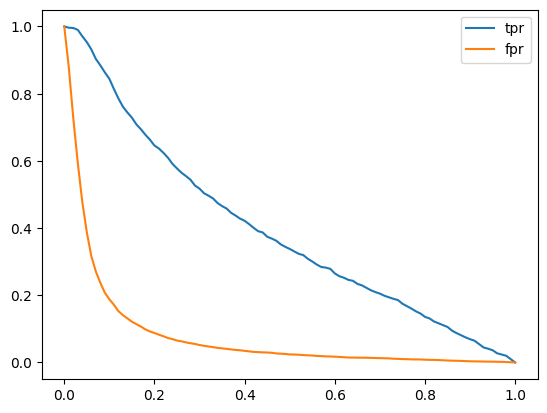

In [121]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'tpr')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'fpr')
plt.legend()

In [119]:
df_scores[df_scores.tpr == df_scores.tpr]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,1098,7944,0,0,1.0,1.0
100,1.0,0,0,1098,7944,0.0,0.0
